# Aqui vai minha tentativa de criar um modelo melhor do que o fornecido da questão

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, roc_auc_score
from feature_engine.imputation import RandomSampleImputer
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Carregando os dados

Percebi que as colunas no json utilizado para medir o valor da área sob a curva ROC são diferentes das colunas utilizadas no dataset de treino, então eu filtrei as colunas.

In [2]:
data = pd.read_csv('/Users/davidubaldo/Neuro/challenge-data-scientist/datasets/credit_01/train.gz', compression='gzip', header=0, sep=',', engine='python')
validation = pd.read_json('monitoring/batch_records.json', orient='records')
data = data[validation.columns]
data_2 = data.copy()

#### Eu queria entender como essas categorias nas listas abaixo estavam distribuídas pelo dataset



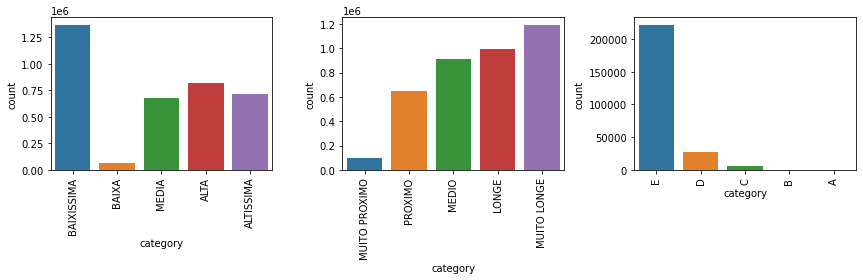

In [3]:
def count_categories(df, categories):
    counts = {}
    for category in categories:
        category_counts = 0
        for column in df.columns:
            category_counts += (df[column] == category).sum()
        counts[category] = category_counts
    return counts

counts_1 = count_categories(data, ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA'])
counts_2 = count_categories(data, ['MUITO PROXIMO', 'PROXIMO', 'MEDIO', 'LONGE', 'MUITO LONGE'])
counts_3 = count_categories(data, ['E', 'D', 'C', 'B', 'A'])


df_counts_1 = pd.DataFrame.from_dict(counts_1, orient='index', columns=['count'])
df_counts_1 = df_counts_1.reset_index()
df_counts_1 = df_counts_1.rename(columns={'index': 'category'})

df_counts_2 = pd.DataFrame.from_dict(counts_2, orient='index', columns=['count'])
df_counts_2 = df_counts_2.reset_index()
df_counts_2 = df_counts_2.rename(columns={'index': 'category'})

df_counts_3 = pd.DataFrame.from_dict(counts_3, orient='index', columns=['count'])
df_counts_3 = df_counts_3.reset_index()
df_counts_3 = df_counts_3.rename(columns={'index': 'category'})

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


sns.barplot(x='category', y='count', data=df_counts_1, ax=axs[0])
sns.barplot(x='category', y='count', data=df_counts_2, ax=axs[1])
sns.barplot(x='category', y='count', data=df_counts_3, ax=axs[2])

for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
    
plt.tight_layout()
plt.show()

# Entendendo como target é distribuído pelo tempo

<AxesSubplot:xlabel='REF_DATE'>

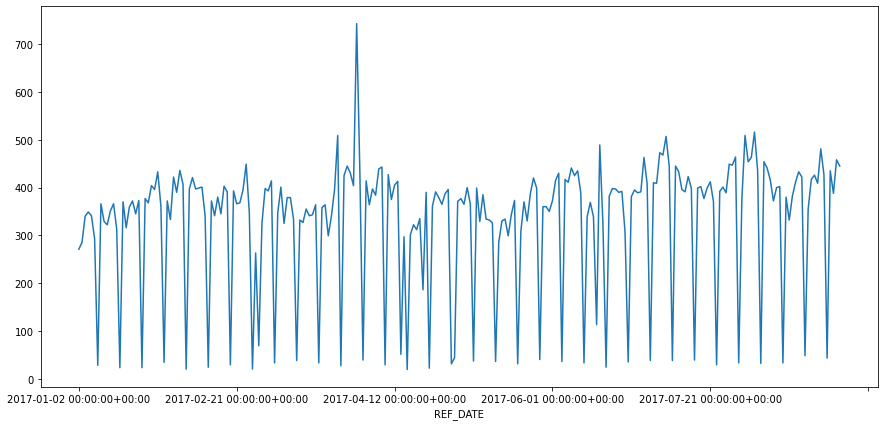

In [4]:
plt.figure(figsize=(15,7))
data.groupby(['REF_DATE'])['TARGET'].sum().plot()

## Distribuição dos dados nos datasets

É possivel identificar que os valores de target estão distribuidos de forma semelhante nos dois datasets, no entanto, as classes 0 e 1 estão desbalanceadas. Terei de levar isso em consideração.

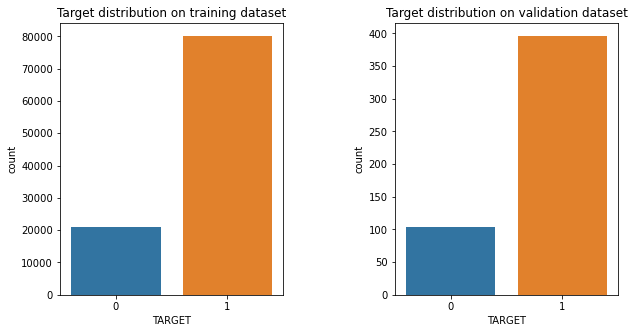

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x="TARGET", data=data, ax=axes[0])
axes[0].set_title("Target distribution on training dataset")

sns.countplot(x="TARGET", data=validation, ax=axes[1])
axes[1].set_title("Target distribution on validation dataset")

plt.subplots_adjust(wspace=0.5)

plt.show()

In [6]:
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
validation['REF_DATE'] = pd.to_datetime(validation['REF_DATE'])

data['MONTH'] = data['REF_DATE'].dt.month
data['DAY'] = data['REF_DATE'].dt.day
data['DAY_WEEK'] = data['REF_DATE'].dt.dayofweek

validation['MONTH'] = validation['REF_DATE'].dt.month
validation['DAY'] = validation['REF_DATE'].dt.day
validation['DAY_WEEK'] = data['REF_DATE'].dt.dayofweek

data = data.drop(columns=['REF_DATE'])
validation = validation.drop(columns=['REF_DATE'])

#### Transformei o REF_DATE em duas outras features que representam o mês e o dia da data. Decidi tirar o ano, pois todos os registros são de 2017 (até no dataset de validação).

In [7]:
data.head(5)

,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR14,VAR15,VAR16,VAR18,VAR19,VAR22,VAR24,VAR25,VAR32,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,TARGET,MONTH,DAY,DAY_WEEK
0,F,76.126,SP,-23.568523,-46.804297,C,E,BAIXA,2.0,0.305,0.146,0.138,NaN,0.503899,0.347735,0.250,0.052,0.129,NaN,0.624806,0.480278,0.526963,0.761115,1.000,S,N,N,S,N,N,N,S,N,N,N,N,S,N,S,S,N,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,MEDIA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,MEDIA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,ALTA,MEDIO,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,LONGE,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MUITO PROXIMO,LONGE,MUITO LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,PROXIMO,MEDIO,MEDIO,LONGE,MUITO PROXIMO,4094.377623,C,1,6,16,4
1,NaN,NaN,SP,-23.189738,-46.815943,NaN,E,MEDIA,0.0,0.205,0.105,0.114,3.833333,0.128767,1.309589,0.250,0.138,0.065,DECLARACAO NAO ENVIADA,0.380323,0.389401,0.421293,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDIA,BAIXISSIMA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,BAIXISSIMA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,ALTA,ALTA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,MEDIA,MEDIA,ALTISSIMA,ALTISSIMA,LONGE,LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,PROXIMO,LONGE,LONGE,MEDIO,LONGE,PROXIMO,LONGE,MUITO LONGE,MEDIO,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MEDIO,PROXIMO,LONGE,MEDIO,MEDIO,MUITO PROXIMO,1347.882336,E,1,2,7,1
2,NaN,NaN,PE,-7.563015,-35.013143,NaN,E,ALTISSIMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211022,0.412692,0.870564,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,LONGE,MUITO LONGE,LONGE,LONGE,PROXIMO,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,MUITO PROXIMO,1428.485398,E,1,3,11,5
3,F,65.786,AM,-3.119028,-60.021731,NaN,E,MEDIA,NaN,0.173,0.129,0.029,NaN,1.493151,0.550685,0.125,0.000,0.000,NaN,0.527175,0.402113,0.327212,0.469793,0.002,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,ALTISSIMA,ALTA,BAIXISSIMA,MEDIA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTA,BAIXISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,MEDIA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,MEDIA,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,PROXIMO,LONGE,LONGE,PROXIMO,PROXIMO,MEDIO,PROXIMO,LONGE,LONGE,PROXIMO,PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,MEDIO,MUITO LONGE,LONGE,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,MEDIO,PROXIMO,MUITO LONGE,LONGE,MEDIO,MEDIO,LONGE,1478.879522,E,1,4,28,4
4,M,24.918,AC,-10.014903,-67.798491,E,E,ALTA,0

In [8]:
missing_perc = data.isna().mean()
columns_with_high_missing = missing_perc[missing_perc > 0.5].index.tolist()
columns_with_high_missing

['VAR15', 'VAR16', 'VAR19', 'VAR22', 'VAR25', 'VAR32']

In [9]:
data = data.drop(columns=columns_with_high_missing)
validation = validation.drop(columns=columns_with_high_missing)

In [10]:
data[['VAR5', 'VAR6', 'VAR7']].isna().sum()

VAR5    2835
VAR6    2835
VAR7    2835
dtype: int64

In [11]:
data = data.drop(columns=['VAR5'])
validation = validation.drop(columns=['VAR5'])

#### Dropei a VAR 5, pois ela pode ser explicada pela VAR6 e VAR7 (provavelmente latitude e longitude).

# Train_test_split

Decidi fazer o split de treino e teste com o StratifiedShuffleSplit, pois os dados estão desbalanceados. Esse método de split preserva a distribuição da variável target nos datasets de treino e teste

In [12]:
target = data["TARGET"]
features = data.drop("TARGET", axis=1)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.02, random_state=69)

train_index, test_index = next(splitter.split(features, target))

X_train, y_train = features.iloc[train_index].copy(), target.iloc[train_index].copy()
X_test, y_test = features.iloc[test_index].copy(), target.iloc[test_index].copy()
validation_x = validation.drop("TARGET", axis=1)
validation_y = validation['TARGET']

In [13]:
print(len(y_train))
print(len(y_test))

99105
2023


# Imputando valores

Usei o RandomSampleImputer para preservar a distribuição dos valores das colunas.

In [14]:
imputer = RandomSampleImputer()
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
validation_x = imputer.transform(validation_x)

# Aplicando o StandardScaler nas variáveis numéricas


In [15]:
scaler = StandardScaler()

num_columns = X_train.select_dtypes(include='number')
scaler.fit(X_train[num_columns.columns].iloc[:, :-3])

X_train.loc[:, num_columns.columns[:-3]] = scaler.transform(X_train.loc[:, num_columns.columns[:-3]])
X_test.loc[:, num_columns.columns[:-3]] = scaler.transform(X_test.loc[:, num_columns.columns[:-3]])
validation_x.loc[:, num_columns.columns[:-3]] = scaler.transform(validation_x.loc[:, num_columns.columns[:-3]])

# Lidando com variáveis categóricas

In [16]:
columns_1 = data.columns[data.isin(['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']).any()]
columns_2 = data.columns[data.isin(['MUITO PROXIMO', 'PROXIMO', 'MEDIO', 'LONGE', 'MUITO LONGE']).any()]
columns_3 = data.columns[data.isin(['E', 'D', 'C', 'B', 'A']).any()]
columns_4 = data.columns[data.isin(['N', 'S']).any()]

encoders = {}

for df in [X_train, X_test, validation_x]:
    for col in columns_1:
        encoder = OrdinalEncoder(categories=[['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']], unknown_value=np.nan, handle_unknown='use_encoded_value')
        encoder.fit(df[[col]])
        encoders[col] = encoder

    for col in columns_2:
        encoder = OrdinalEncoder(categories=[['MUITO PROXIMO', 'PROXIMO', 'MEDIO', 'LONGE', 'MUITO LONGE']], unknown_value=np.nan, handle_unknown='use_encoded_value')
        encoder.fit(df[[col]])
        encoders[col] = encoder

    for col in columns_3:
        encoder = OrdinalEncoder(categories=[['E', 'D', 'C', 'B', 'A']], unknown_value=np.nan, handle_unknown='use_encoded_value')
        encoder.fit(df[[col]])
        encoders[col] = encoder

    for col in columns_4:
        encoder = OrdinalEncoder(categories=[['N', 'S']], unknown_value=np.nan, handle_unknown='use_encoded_value')
        encoder.fit(df[[col]])
        encoders[col] = encoder
        

    for col, encoder in encoders.items():
        df[col] = encoder.transform(df[[col]])

#### Decidi usar o OrdinalEncoder para lidar com as variáveis que possuem as categorias acima. Eu suponho que há alguma ordem nelas, no entanto, fica difícil definir a ordem de relevância para o modelo, já que eu não tenho nenhuma informação do que elas representam.

In [17]:
X_train_one_hot = pd.get_dummies(X_train['VAR2'], drop_first=True)
X_test_one_hot = pd.get_dummies(X_test['VAR2'], drop_first=True)
validation_x_one_hot = pd.get_dummies(validation_x['VAR2'], drop_first=True)

X_train = pd.concat([X_train_one_hot, X_train], axis=1).drop(columns=['VAR2'])
X_test = pd.concat([X_test_one_hot, X_test], axis=1).drop(columns=['VAR2'])
X_test['I'] = 0

validation_x = pd.concat([validation_x_one_hot, validation_x], axis=1).drop(columns=['VAR2'])
validation_x['I'] = 0

X_test = X_test[X_train.columns]
validation_x = validation_x[X_train.columns]

#### No caso da VAR2, que representa o sexo, não há nenhuma ordem, então é ideal utilizar o OneHotEncoding (dropando F para evitar multicolinearidade)

# Treinando os modelos escolhidos 

Decidi utilizar RandomForest e XGBoost, pois modelos ensemble possuem geralmente um desempenho melhor do que modelos isolados. 

In [23]:
rfc = RandomForestClassifier(n_estimators=200,
                              max_depth=10,
                              min_samples_split=16,
                              class_weight='balanced',
                              max_samples=0.7,
                              random_state=69)
    
xgb = XGBClassifier(n_estimators=200,
                              max_depth=10,
                              min_child_weight=16,
                              scale_pos_weight=0.25,
                              subsample=0.7,
                              random_state=69)



rfc.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=16, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)

In [24]:
y_pred_rfc = rfc.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
    
y_probs_rfc = rfc.predict_proba(X_test)[:,1]
y_probs_xgb = xgb.predict_proba(X_test)[:,1]
 

roc_rfc = roc_auc_score(y_test, y_probs_rfc)
roc_xgb = roc_auc_score(y_test, y_probs_xgb)
    
print(roc_rfc)
print(roc_xgb)
print(classification_report(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_xgb))

0.6776743011615126
0.6323604550990702
              precision    recall  f1-score   support

           0       0.32      0.60      0.41       420
           1       0.86      0.66      0.75      1603

    accuracy                           0.65      2023
   macro avg       0.59      0.63      0.58      2023
weighted avg       0.75      0.65      0.68      2023

              precision    recall  f1-score   support

           0       0.31      0.44      0.36       420
           1       0.83      0.74      0.78      1603

    accuracy                           0.68      2023
   macro avg       0.57      0.59      0.57      2023
weighted avg       0.72      0.68      0.70      2023



In [25]:
X_test_score = X_test.copy()
X_test_score['xgb_score'] = y_probs_xgb
X_test_score['rfc_score'] = y_probs_rfc
X_test_score['TARGET'] = y_test

(0.0, 1.0)

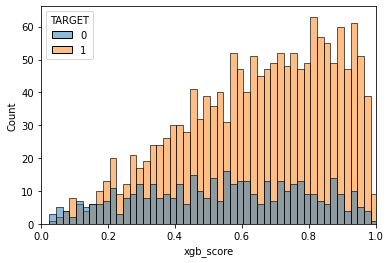

In [51]:
sns.histplot(x=X_test_score['xgb_score'], hue=X_test_score['TARGET'], binwidth=0.02)
plt.xlim(0,1)

(0.0, 1.0)

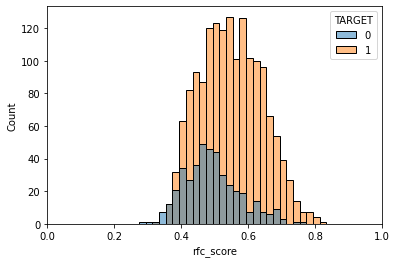

In [52]:
sns.histplot(x=X_test_score['rfc_score'], hue=X_test_score['TARGET'], binwidth=0.02)
plt.xlim(0,1)

In [30]:
y_probs_rfc_val = rfc.predict_proba(validation_x)[:,1]
y_probs_xgb_val = xgb.predict_proba(validation_x)[:,1]

roc_rfc_val = roc_auc_score(validation_y, y_probs_rfc_val)
roc_xgb_val = roc_auc_score(validation_y, y_probs_xgb_val)

print(roc_rfc_val)
print(roc_xgb_val)

0.6218434343434344
0.6117181429681429


# Avaliação dos modelos

## Random Forest

O Random Forest conseguiu 0.05 a mais de ROC score, comparado ao modelo dado pelo case. Analisando a distribuição dos scores nos histogramas, nos níveis mais altos há uma maior prevalência de amostras da classe 1 em detrimento da classe 0, já no outro lado da distribuição, o comportamento é o inverso.

## XGBoost

O XGBoost conseguiu 0.04 a mais de ROC score, comparado ao modelo dado pelo case. É possível observar que o XGBoost possui uma maior incidência de falsos positivos.

## Conclusão 

Um modelo poderia ser escolhido com base na importância de cada métrica (precision e recall), isso teria de ser avaliado, pois é possível alterar o limiar de classificação do modelo para dar prioridade a qualquer uma dessas métricas, dada uma classe.
Vale salientar que não fiz nenhum hyperparameter tuning, o que poderia melhorar ainda mais o desempenho do modelo. 